Test CAMEMBERT

In [31]:
import os 
import pandas as pd
import tensorflow_hub as hub
#import tokenization
import numpy as np
from bert import tokenization
# from bert import bert_tokenization

In [2]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

['preserve_unused_tokens=False']

In [3]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
#module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"

bert_layer = hub.KerasLayer(module_url, trainable=True)

In [5]:
p = r'C:\Users\david\Downloads\PortableGit\projet_final_\BERT_Easy_Implementation\data'
f_train = os.path.join(p, '', 'train.csv')
f_test = os.path.join(p, '', 'test.csv')

train = pd.read_csv(f_train)
test = pd.read_csv(f_test)

In [6]:
train.head(3)

,text,label
0,"Now, I won't deny that when I purchased this o...",0
1,"The saddest thing about this ""tribute"" is that...",0
2,Last night I decided to watch the prequel or s...,0


In [16]:
train.shape

(25000, 2)

BERT à un encoding spécial : **Byte-Pair Encoding (BPE)**</br>

BPE est un algorithme de tokenisation ascendante de sous-mots qui apprend un vocabulaire de sous-mots d’une certaine taille (la taille du vocabulaire étant un hyperparamètre). L’idée de base est la suivante :

1. Commencez par diviser tous les mots en caractères unicode. Chaque caractère unicode correspond à un symbole dans le vocabulaire final. Nous commencerons avec ce vocabulaire minimal et l’élargirons progressivement.

2. Tant qu’il reste de la place dans le vocabulaire, faites ce qui suit :

    * Trouvez le symbole bigramme le plus fréquent (paire de symboles)
    * Fusionnez ces symboles pour créer un nouveau symbole et ajoutez-le au vocabulaire. Ceci augmente la taille du vocabulaire de 1.

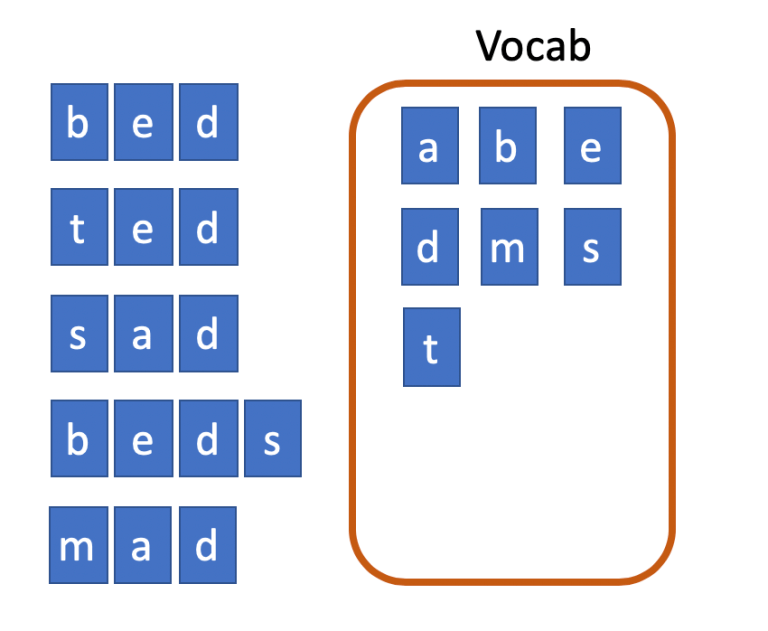

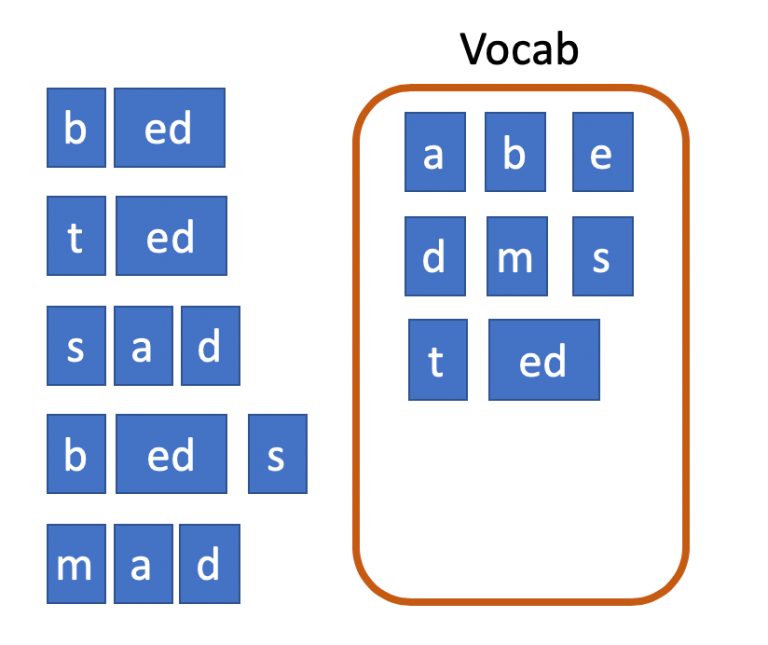

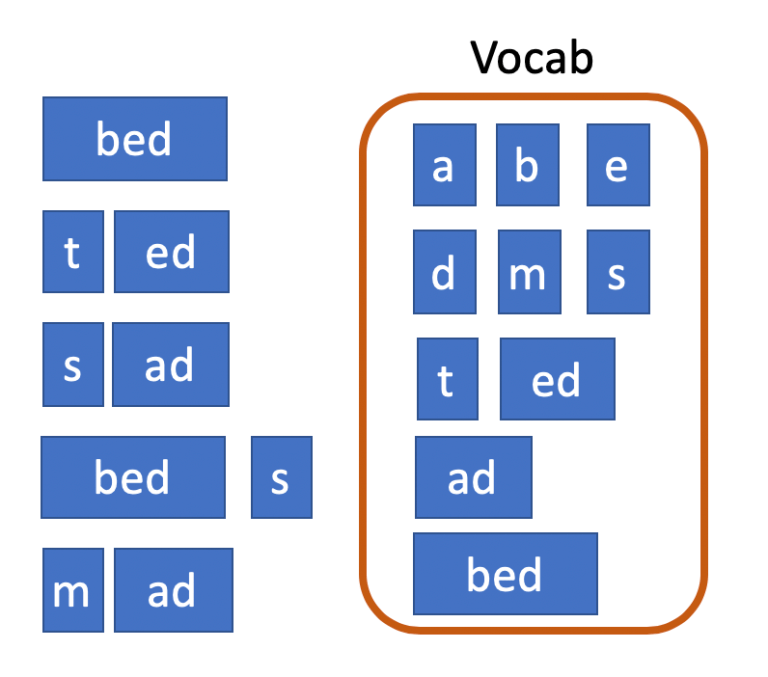

https://lbourdois.github.io/blog/nlp/Les-tokenizers/#:~:text=BPE%20est%20un%20algorithme%20de,les%20mots%20en%20caract%C3%A8res%20unicode.

In [17]:
def bert_encode(texts, tokenizer, max_len=128):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

On initialise le tokenizer en allant chercher dans le modèle BERT à la fois la liste de vocabulaire et leur index / chiffre associé et la fonction pour passer les mots en lettres majuscules en minuscules.

In [18]:
# Nombre de mots total du texte (vocabulaire)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

# Mettre le texte en minuscule 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# Tokenization de BERT
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Pour chaque csv (train et test), on créer deux variables contenant :
* les phrases encodées pour BERT
* les labels sur lesquel BERT doit s’entraîner / prédire

In [19]:
train_input = bert_encode(train.text.values, tokenizer, max_len=100)
test_input = bert_encode(test.text.values, tokenizer, max_len=100)

train_labels = train.label.values
test_labels = test.label.values

### Transfer Learning

Il va falloir ajouter:
* les layers d'entrées : une pour chaque liste, donc trois couches
* la layer de sortie : on fait de la classisification binaire donc une seule couche

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")  # Input_words (512,)
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")          # Input_mask  (512,)
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")        # Segment_ind (512,)

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])       # BERT_layer = inp_word + inp_mask + segm
    clf_output = sequence_output[:, 0, :]                                            # BERT_layer  (100, 768,)
    out = Dense(1, activation='sigmoid')(clf_output)                                 # Dense (1,)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(learning_rate=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [21]:
model = build_model(bert_layer, max_len=100)

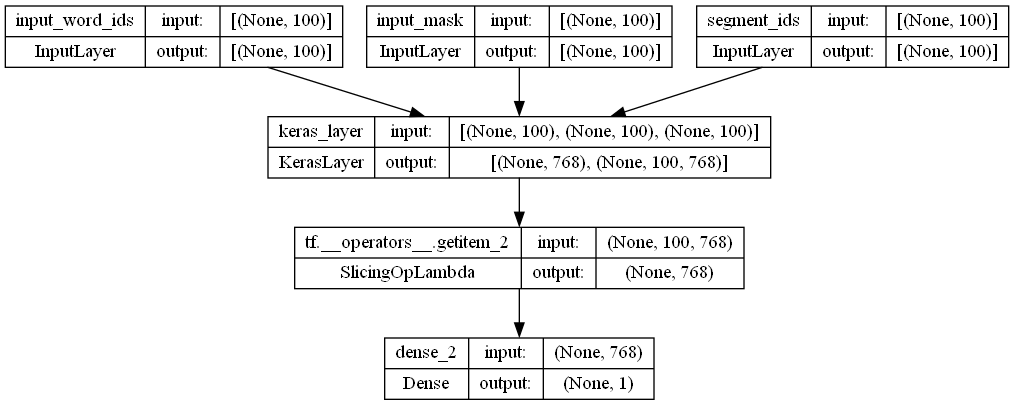

In [22]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Notre modèle à trois entrées qui se rejoignent pour former réseau de layers uniques.

La couche KerasLayer (la couche de BERT) contient plusieurs autres couches.

Elles ne sont pas visible ici (chargées depuis TensorFlow Hub) avec le modèle : `bert_en_uncased_L-12_H-768_A-12` 

* **`L-12`** : 12 couches caché (12 Layers)
* **`H-768`** : une « taille caché » de 768, en fait 768 neurones (768 Hidden size)
* **`A-12`** : 12 module d’Attention, ces modules servent à faire des calcules en parallèles (12 attention head)
* **`en_uncase`** :texte mis en minuscules pendant le preprocessing.

In [24]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=5,
    batch_size=16
)

Epoch 1/5
1250/1250 [==============================] - 337s 264ms/step - loss: 0.4111 - accuracy: 0.8026 - val_loss: 0.3388 - val_accuracy: 0.8466
Epoch 2/5
1250/1250 [==============================] - 329s 263ms/step - loss: 0.2799 - accuracy: 0.8812 - val_loss: 0.3382 - val_accuracy: 0.8464
Epoch 3/5
1250/1250 [==============================] - 331s 265ms/step - loss: 0.2008 - accuracy: 0.9219 - val_loss: 0.3465 - val_accuracy: 0.8542
Epoch 4/5
1250/1250 [==============================] - 331s 265ms/step - loss: 0.1181 - accuracy: 0.9621 - val_loss: 0.4027 - val_accuracy: 0.8548
Epoch 5/5
1250/1250 [==============================] - 338s 270ms/step - loss: 0.0514 - accuracy: 0.9882 - val_loss: 0.5076 - val_accuracy: 0.8526


Les poids des neurones de BERT sont entraînés mais pas les poids des nouvelles layers.

**Transfer Learning** : on effectur un entraînement sur tout le modèle. Les nouvelles couches vont alors s’adapter aux poids de BERT (on poursuit l'entrainement que GOOGLE à déja réalisé)

In [25]:
model.evaluate(test_input, test_labels)

782/782 [==============================] - 117s 149ms/step - loss: 0.4962 - accuracy: 0.8546


[0.49619340896606445, 0.8545600175857544]

In [26]:
model.predict(bert_encode(["I liked this movie"], tokenizer, max_len=100))

1/1 [==============================] - 3s 3s/step


array([[0.95524716]], dtype=float32)

In [27]:
model.predict(bert_encode(["Everything was fine but not the movie !"], tokenizer, max_len=100))

1/1 [==============================] - 0s 87ms/step


array([[0.02768317]], dtype=float32)

In [30]:
model.save('./Saving_model_camembert/model.h5')

In [29]:
os.getcwd()

'C:\\Users\\david\\JEDHA BOOTCAMP\\FULLSTACK\\10_PROJECT\\FINAL_PROJECT'

In [ ]:
#from tensorflow import keras
#model = keras.models.load_model('./Saving_model_camembert/model.h5')